In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import shutil
import cobra as cb
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import logging
import glob

plt.style.use('ggplot')

c:\Users\LL331070\AppData\Local\anaconda3\envs\data_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
folder_path = '../dati_sampling/dati/sampling/CBS_total/'

In [3]:
test_df = pd.read_pickle(f"{folder_path}22RV1_PROSTATE.pkl")
test_df.head()

,EX_lac__L_e,EX_glc__D_e,EX_glu__L_e,EX_gln__L_e,EX_asp__L_e,EX_co2_e,EX_h_e,EX_h2o_e,EX_pi_e,EX_nh4_e,...,t_Lcystin_glu__L,t_Lcystin_leu__L,t_Lcystin_ser__L,CSNATr,CRNCARtm,CSNATm,ACS,ACt2m,PyrODC,Incompox_Pyr
0,-0.0,-9.955851,-0.136054,-1.680421,-0.108721,76.328957,24.213789,48.410384,-0.009587,6.507184,...,0.071578,0.13609,-0.0,14.9857,14.9857,14.9857,15.029344,-15.029344,-0.0,15.029344
1,-0.0,-9.955851,-0.136054,-1.680421,-0.108721,76.365562,24.602162,48.410384,-0.009587,6.516335,...,0.092661,-0.0,0.115006,15.186635,15.186635,15.186635,15.230279,-15.230279,-0.0,15.230279
2,13.325536,-6.266929,-0.136054,-1.680421,-0.108721,3.539296,10.173699,-3.231103,-0.253135,3.536894,...,-0.0,0.13609,-0.0,2.088856,2.088856,2.088856,-0.0,0.0,-0.0,-0.0
3,-0.0,-8.370928,-0.136054,0.013882,-0.108721,48.90833,0.783075,48.410384,-0.214602,-0.0,...,-0.0,0.13609,-0.0,1.296368,1.296368,1.296368,1.781729,-1.781729,1.781729,-0.0
4,0.0,-9.955851,-0.136054,-1.680421,-0.108721,51.442666,75.59461,48.410384,-0.009587,0.511113,...,-0.0,-0.0,0.13609,-94.454304,-94.454304,-94.454304,-0.0,0.0,-0.0,-0.0


### Calcolo std e mean

In [ ]:
import numpy as np
import pandas as pd

def compute_fluxes_std_mean(sample_df: pd.DataFrame) -> dict:
    """
    - Prende in input un DataFrame sample_df (righe = osservazioni/cellule, 
      colonne = flussi o metaboliti).
    - Usa la funzione is_tca_non_canonico per identificare le righe “non canoniche”:
          HMR_4964 > 1e-6  AND  ACITL > 1e-6  AND  MDH < 1e-6
    - Se non ci sono righe non canoniche, restituisce NaN per tutte le reazioni.
    - Altrimenti, calcola media e std colonna‐per‐colonna sulle righe filtrate.
    - Restituisce un dict con:
        • "reaction"  = lista dei nomi di tutte le colonne di sample_df
        • "mean_flux" = array NumPy di lunghezza n_colonne (media su righe non canoniche)
        • "std_flux"  = array NumPy di lunghezza n_colonne (std su righe non canoniche)
    """

    def is_tca_non_canonico(row):
        return (row['HMR_4964'] > 1e-6) and \
               (row['ACITL'] > 1e-6) and \
               (row['MDH'] < -1e-6)

    col_names = list(sample_df.columns)

    mask_non_canonico = sample_df.apply(is_tca_non_canonico, axis=1)  # Series[bool]

    df_non_canonico = sample_df.loc[mask_non_canonico]

    if df_non_canonico.shape[0] == 0:
        nan_arr = np.full(len(col_names), np.nan)
        print("No non-canonical rows found. Returning NaN arrays for all reactions.")
        return {
            "reaction":  col_names,
            "mean_flux": nan_arr,
            "std_flux":  nan_arr
        }

    mean_series = df_non_canonico.mean(axis=0) 
    std_series  = df_non_canonico.std(axis=0)   

    # 6) Converto in array NumPy
    mean_flux = mean_series.to_numpy()
    std_flux  = std_series.to_numpy()

    return {
        "reaction":  col_names,
        "mean_flux": mean_flux,
        "std_flux":  std_flux
    }


In [20]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def process_file(file_path: str) -> dict:

    try:
        # Carico il DataFrame
        df = pd.read_pickle(file_path)
        if not isinstance(df, pd.DataFrame):
            raise ValueError("Il pickle non contiene un DataFrame")

        flux_stats = compute_fluxes_std_mean(sample_df=df)
        file_name_old = os.path.basename(file_path)
        file_name, _ = os.path.splitext(file_name_old)

        flux_stats["cell_line"] = file_name

        logging.info(f"Processed {file_name} successfully.")
        return flux_stats

    except Exception as e:
        logging.error(f"Error processing {file_path}: {e}")
        return None

In [21]:
file_paths = glob.glob('../dati_sampling/dati/sampling/CBS_total/*.pkl')

results_list = Parallel(n_jobs=-1)(
    delayed(process_file)(file_path) for file_path in tqdm(file_paths)
)

results_list = [res for res in results_list if res is not None]

rows = []
for stats in results_list:
    cell_line = stats["cell_line"]
    reactions = stats["reaction"]      
    means     = stats["mean_flux"]    
    stds      = stats["std_flux"]     

    for rxn_name, mu, sigma in zip(reactions, means, stds):
        rows.append({
            "cell_line": cell_line,
            "reaction":  rxn_name,
            "mean_flux": float(mu),    
            "std_flux":  float(sigma)
        })

results_df = pd.DataFrame(rows)


100%|██████████| 513/513 [12:23<00:00,  1.45s/it]


### flux redirections

In [3]:
tca_states = pd.read_csv('../script/tca_count_df.csv', index_col=0)
tca_states

,TCA canonical,TCA non canonical,both active,biomass mean canonical,biomass mean non canonical,biomass mean both active,activity mean TCA canonical,activity mean TCA non canonical,Valid samples
22RV1_PROSTATE,0.1376,0.3547,84,0.047183,0.076068,0.043725,2.473520,14.794442,0.4923
2313287_STOMACH,0.1131,0.3046,41,0.058132,0.090999,0.094560,0.988751,13.072795,0.4177
5637_URINARY_TRACT,0.1265,0.5422,285,0.045263,0.054712,0.026731,5.801186,12.879744,0.6687
697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.1531,0.5623,188,0.046094,0.057049,0.033776,3.529251,10.430198,0.7154
769P_KIDNEY,0.0898,0.4553,218,0.036136,0.062512,0.018129,7.481572,17.514556,0.5451
...,...,...,...,...,...,...,...,...,...
YD15_SALIVARY_GLAND,0.1287,0.5833,299,0.046033,0.053492,0.025115,5.250382,11.371697,0.7120
YD38_UPPER_AERODIGESTIVE_TRACT,0.1347,0.5822,319,0.046244,0.053200,0.026316,5.083043,11.212096,0.7169
YD8_UPPER_AERODIGESTIVE_TRACT,0.1436,0.4779,350,0.038505,0.061327,0.022905,4.564598,13.736960,0.6215
ZR751_BREAST,0.1597,0.3653,106,0.043367,0.066594,0.045626,1.502184,10.843867,0.5250


In [ ]:
# results_df.to_csv("mean_std_fluxes.csv", index=False)

In [4]:
results_df = pd.read_csv("mean_std_fluxes.csv")
results_df.head()

,cell_line,reaction,mean_flux,std_flux
0,22RV1_PROSTATE,EX_lac__L_e,9.218231,7.987174
1,22RV1_PROSTATE,EX_glc__D_e,-7.924945,2.669225
2,22RV1_PROSTATE,EX_glu__L_e,-0.123480,0.181964
3,22RV1_PROSTATE,EX_gln__L_e,-1.598535,0.359733
4,22RV1_PROSTATE,EX_asp__L_e,-0.078053,0.341534


In [8]:
results_df.columns

Index(['cell_line', 'reaction', 'mean_flux', 'std_flux'], dtype='object')

Rate limiting reaction

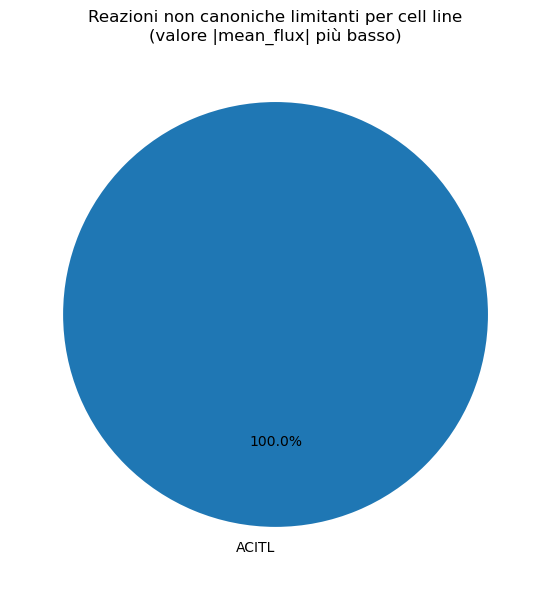

In [ ]:
def plot_limiting_non_canonical(results_df):

    non_canonical = ['HMR_4964', 'ACITL', 'MDH']

    nc_df = results_df[results_df['reaction'].isin(non_canonical)].copy()

    idx_min = nc_df.groupby('cell_line')['mean_flux'] \
                   .apply(lambda x: x.abs().idxmin())

    limiting = nc_df.loc[idx_min]

    counts = limiting['reaction'].value_counts()

    plt.figure(figsize=(6,6))
    counts.plot.pie(
        autopct='%1.1f%%',
        startangle=90,
        labels=counts.index
    )
    plt.ylabel('')
    plt.title('Reazioni non canoniche limitanti per cell line\n(valore |mean_flux| più basso)')
    plt.tight_layout()
    plt.show()

plot_limiting_non_canonical(results_df)

In [5]:
from scipy.stats import pearsonr, spearmanr

def plot_reaction_propensity_correlation(
    reaction_name: str,
    results_df: pd.DataFrame,
    tca_states: pd.DataFrame
) -> tuple:


    subset = results_df.loc[
        results_df['reaction'] == reaction_name,
        ['cell_line', 'mean_flux', 'std_flux']
    ].copy()

    if subset.empty:
        raise ValueError(f"Nessuna entry trovata in results_df per la reazione '{reaction_name}'")

    subset.set_index('cell_line', inplace=True)

    if 'cell_line' in tca_states.columns:
        tca_idx = tca_states.set_index('cell_line')['TCA non canonical']
    else:
        tca_idx = tca_states['TCA non canonical']

    subset = subset.join(tca_idx.rename("propensity"), how='inner')

    if subset.empty:
        raise ValueError("Dopo il merge non ci sono più righe comuni fra results_df e tca_states.")

    corr, p_value = pearsonr(subset["propensity"], subset["mean_flux"])

    plt.figure(figsize=(6, 5))
    sns.regplot(
        x="propensity",
        y="mean_flux",
        data=subset,
        ci=None,
        scatter_kws={"s": 40, "alpha": 0.7},
        line_kws={"color": "red"}
    )
    plt.xlabel("TCA non canonical propensity")
    plt.ylabel(f"Mean flux of {reaction_name}")
    plt.title(
        f"Reazione '{reaction_name}': spearmanr rho = {corr:.2f}, p = {p_value:.2e}"
    )
    plt.tight_layout()
    plt.show()

    return corr, p_value


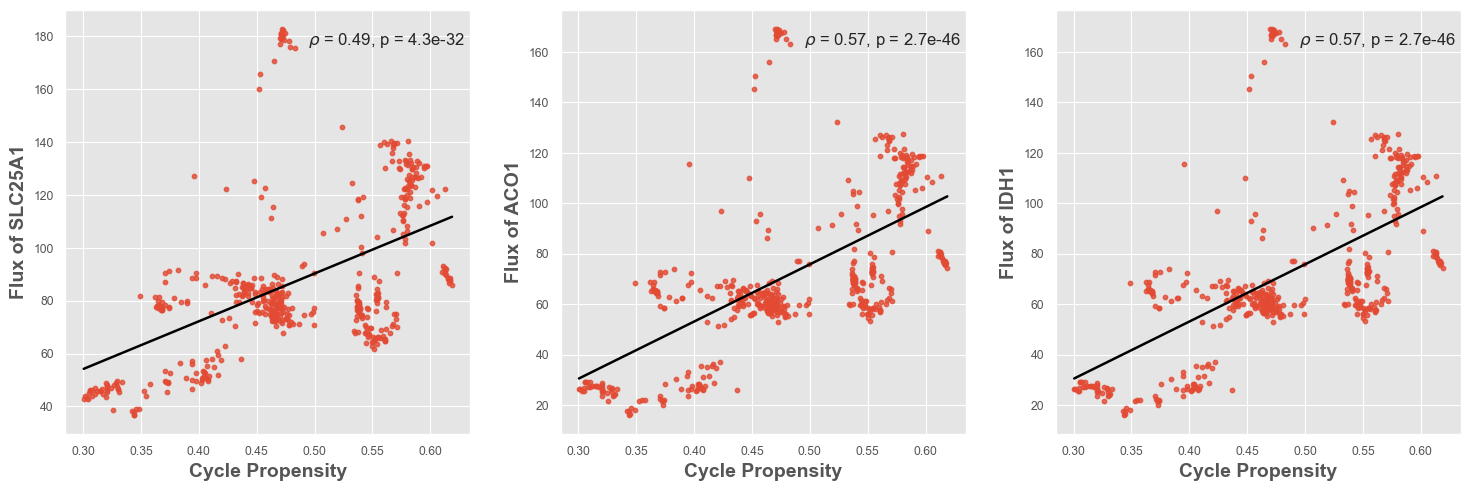

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

plt.style.use('ggplot')
sns.set_context("paper")

# Reazioni da plottare
reactions = {
    "HMR_4964": "SLC25A1",
    "ACONT": "ACO1",
    "ICDHyr": "IDH1"
}

# Setup figura
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

for ax, (reaction_id, reaction_label) in zip(axes, reactions.items()):
    # Prepara dati
    subset = results_df.loc[results_df['reaction'] == reaction_id, ['cell_line', 'mean_flux']].copy()
    subset = subset.set_index('cell_line')
    tca_idx = tca_states['TCA non canonical']
    subset = subset.join(tca_idx.rename("propensity"), how='inner')

    # Calcolo correlazione
    corr, pval = pearsonr(subset['propensity'], subset['mean_flux'])

    # Plot
    sns.regplot(
        x='propensity',
        y='mean_flux',
        data=subset,
        ci=None,
        scatter_kws={'s': 10},
        line_kws={'color': 'black'},
        ax=ax
    )

    # Etichette
    ax.set_xlabel("Cycle Propensity", fontsize=14, fontweight='bold')
    ax.set_ylabel(f"Flux of {reaction_label}", fontsize=14, fontweight='bold')

    # Annotazione rho e p
    ax.text(0.6, 0.95, f"$\\rho$ = {corr:.2f}, p = {pval:.1e}",
            transform=ax.transAxes,
            fontsize=12,
            verticalalignment='top')

plt.tight_layout()
plt.show()
